In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention with missings values > -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'<10':0, '10<20': 1, '20<50':2, '50<100':3, '100<500':4, '500<1000':5, '1000<5000':6, '>5000':7}).astype(np.int16)

# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# Machine Learning

In [9]:
numerical, categorical=list(), list()
for x in all_data.columns : 
    if x  in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] :
        numerical.append(all_data.columns.get_loc(x))
    else :
        categorical.append(all_data.columns.get_loc(x))
        
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:,self.columns]

In [10]:
def run_gridSearchCV(scaler):
    
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    imputer = Imputer(strategy='mean', missing_values=-1) 

    cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=0)
    classifier = MLPClassifier(hidden_layer_sizes=(295, 295), random_state=0)
    
    pNumerical = make_pipeline(ColumnSelector(columns=numerical), scaler)
    pCategorical = make_pipeline(ColumnSelector(columns=categorical))
    pNumericalCategorical=FeatureUnion(n_jobs =1, transformer_list=[('1',pNumerical),('2',pCategorical)])
    pipeline = Pipeline((('imp', imputer), ('pls', pNumericalCategorical), ('clf', classifier)))

    params = {
        'clf__max_iter': np.linspace(9,15,7, dtype=int)
    }
    gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=1, scoring='f1_weighted', return_train_score =True)
    gs.fit(X_train,y_train)

    cv_results = pd.DataFrame(gs.cv_results_)[['param_clf__max_iter', 'mean_test_score', 'std_test_score']]
    cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
    print(gs.best_params_)

    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(cv_results['param_clf__max_iter'],cv_results['mean_test_score'],'-o')
    plt.subplot(2,1,2)
    plt.plot(cv_results['param_clf__max_iter'],cv_results['std_test_score'],'-o')
    plt.show()

{'clf__max_iter': 9}


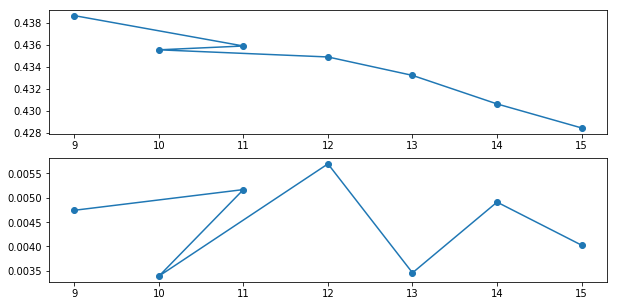

Wall time: 15min 28s


In [11]:
%%time
run_gridSearchCV(StandardScaler())

{'clf__max_iter': 9}


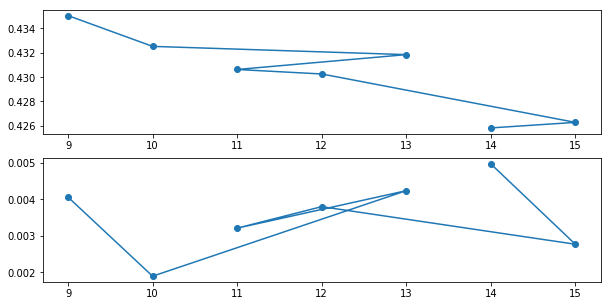

Wall time: 16min 1s


In [12]:
%%time
run_gridSearchCV(MinMaxScaler())

{'clf__max_iter': 9}


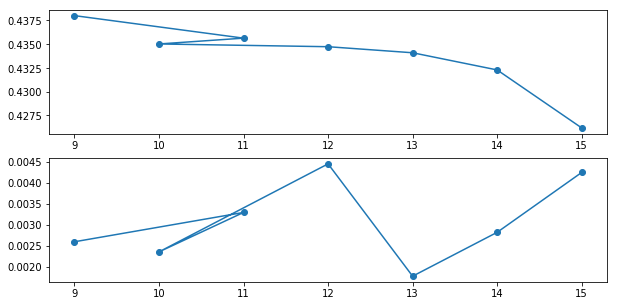

Wall time: 15min 22s


In [13]:
%%time
run_gridSearchCV(RobustScaler())

{'clf__max_iter': 9}


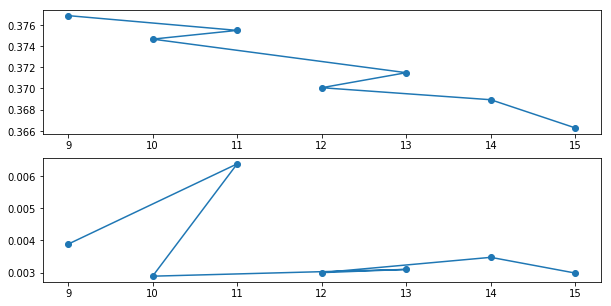

Wall time: 15min 21s


In [14]:
%%time
run_gridSearchCV(Normalizer())

In [15]:
def run_classifier(_max_iter, scaler):
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    imputer = Imputer(strategy='mean', missing_values=-1) 

    classifier = MLPClassifier(hidden_layer_sizes=(295, 295),max_iter=_max_iter, random_state=0)
    pNumerical = make_pipeline(ColumnSelector(columns=numerical), scaler)
    pCategorical = make_pipeline(ColumnSelector(columns=categorical))
    pNumericalCategorical=FeatureUnion([('1',pNumerical),('2',pCategorical)])
    pipeline = Pipeline((('imp', imputer), ('pls', pNumericalCategorical), ('clf', classifier)))

    pipeline.fit(X_train, y_train)
    y_test_predicted = pipeline.predict(X_test)

    y_test_predicted_label = target_vectoriser(y_test_predicted)
    y_test_label = target_vectoriser(y_test)
    print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), lb.fit_transform(y_test_predicted), average='weighted'), '\n')
    print(classification_report(y_test_label, y_test_predicted_label))

In [16]:
%%time
run_classifier(10, StandardScaler())

f1_score:       0.43983395993121027 
roc_auc_score:  0.6725948852202389 

                          precision    recall  f1-score   support

                       -       0.59      0.85      0.69      3059
                 DAMAGED       0.29      0.28      0.29      1159
               DIFFERENT       0.34      0.08      0.12       836
                    FAKE       0.25      0.04      0.07        24
            NOT_RECEIVED       0.46      0.56      0.50      2831
SELLER_CANCEL_POSTERIORI       0.46      0.42      0.44      2698
               UNDEFINED       0.29      0.14      0.19       790
              WITHDRAWAL       0.31      0.17      0.22      1365

             avg / total       0.44      0.47      0.44     12762

Wall time: 26.9 s


In [17]:
%%time
run_classifier(10, MinMaxScaler())

f1_score:       0.4346499571911896 
roc_auc_score:  0.6700153494085493 

                          precision    recall  f1-score   support

                       -       0.58      0.84      0.69      3059
                 DAMAGED       0.26      0.27      0.27      1159
               DIFFERENT       0.36      0.07      0.11       836
                    FAKE       0.00      0.00      0.00        24
            NOT_RECEIVED       0.46      0.56      0.50      2831
SELLER_CANCEL_POSTERIORI       0.46      0.43      0.44      2698
               UNDEFINED       0.31      0.11      0.16       790
              WITHDRAWAL       0.31      0.16      0.21      1365

             avg / total       0.44      0.47      0.43     12762

Wall time: 26.4 s


In [18]:
%%time
run_classifier(10, RobustScaler())

f1_score:       0.4410340484257296 
roc_auc_score:  0.6729460312185475 

                          precision    recall  f1-score   support

                       -       0.58      0.84      0.69      3059
                 DAMAGED       0.29      0.29      0.29      1159
               DIFFERENT       0.31      0.08      0.12       836
                    FAKE       0.33      0.08      0.13        24
            NOT_RECEIVED       0.47      0.54      0.51      2831
SELLER_CANCEL_POSTERIORI       0.46      0.44      0.45      2698
               UNDEFINED       0.30      0.13      0.18       790
              WITHDRAWAL       0.30      0.18      0.22      1365

             avg / total       0.44      0.47      0.44     12762

Wall time: 26.1 s


In [19]:
%%time
run_classifier(10, Normalizer())

f1_score:       0.3778868452060886 
roc_auc_score:  0.6278445514871518 

                          precision    recall  f1-score   support

                       -       0.50      0.63      0.56      3059
                 DAMAGED       0.22      0.32      0.26      1159
               DIFFERENT       0.25      0.05      0.09       836
                    FAKE       0.00      0.00      0.00        24
            NOT_RECEIVED       0.41      0.49      0.45      2831
SELLER_CANCEL_POSTERIORI       0.40      0.39      0.39      2698
               UNDEFINED       0.31      0.11      0.16       790
              WITHDRAWAL       0.31      0.17      0.22      1365

             avg / total       0.38      0.40      0.38     12762

Wall time: 26.7 s
